In [1016]:
import pandas as pd
import numpy as np
import seaborn as sn
import math
import datetime as dt
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

%matplotlib inline

## 1. Data Fetching & Engineering

### 1.1 COVID19 Cases

In [1577]:
# import dataset
path = "C:\\Users\\Marwan\\Desktop\\Codestacker\\dataset.xlsx"
data = pd.read_excel(path, sheet_name=['General', 'Vaccinations', 'Mobility_Report_2020', 'Mobility_Report_2021', 'Government_Measures'])

In [990]:
# check if columns contain null data
general_data = data["General"]
# general_data = general_data.set_index('date')
general_data.isnull().any()

date                        False
total_cases                 False
new_cases                   False
total_deaths                 True
new_deaths                   True
total_cases_per_million     False
new_cases_per_million       False
total_deaths_per_million     True
new_deaths_per_million       True
stringency_index             True
dtype: bool

In [497]:
# fill null with zeros
general_data = general_data.fillna(0)
general_data.isnull().any()

total_cases                 False
new_cases                   False
total_deaths                False
new_deaths                  False
total_cases_per_million     False
new_cases_per_million       False
total_deaths_per_million    False
new_deaths_per_million      False
stringency_index            False
dtype: bool

In [300]:
general_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 426 entries, 2020-02-24 to 2021-04-24
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   total_cases               426 non-null    int64  
 1   new_cases                 426 non-null    int64  
 2   total_deaths              426 non-null    float64
 3   new_deaths                426 non-null    float64
 4   total_cases_per_million   426 non-null    float64
 5   new_cases_per_million     426 non-null    float64
 6   total_deaths_per_million  426 non-null    float64
 7   new_deaths_per_million    426 non-null    float64
 8   stringency_index          426 non-null    float64
dtypes: float64(7), int64(2)
memory usage: 33.3+ KB


In [301]:
# plot a map of correlations between columns
plt.figure(figsize=(12, 8))
correlations = general_data.corr()
sn.heatmap(correlations, annot=True, cmap="copper")
plt.show()

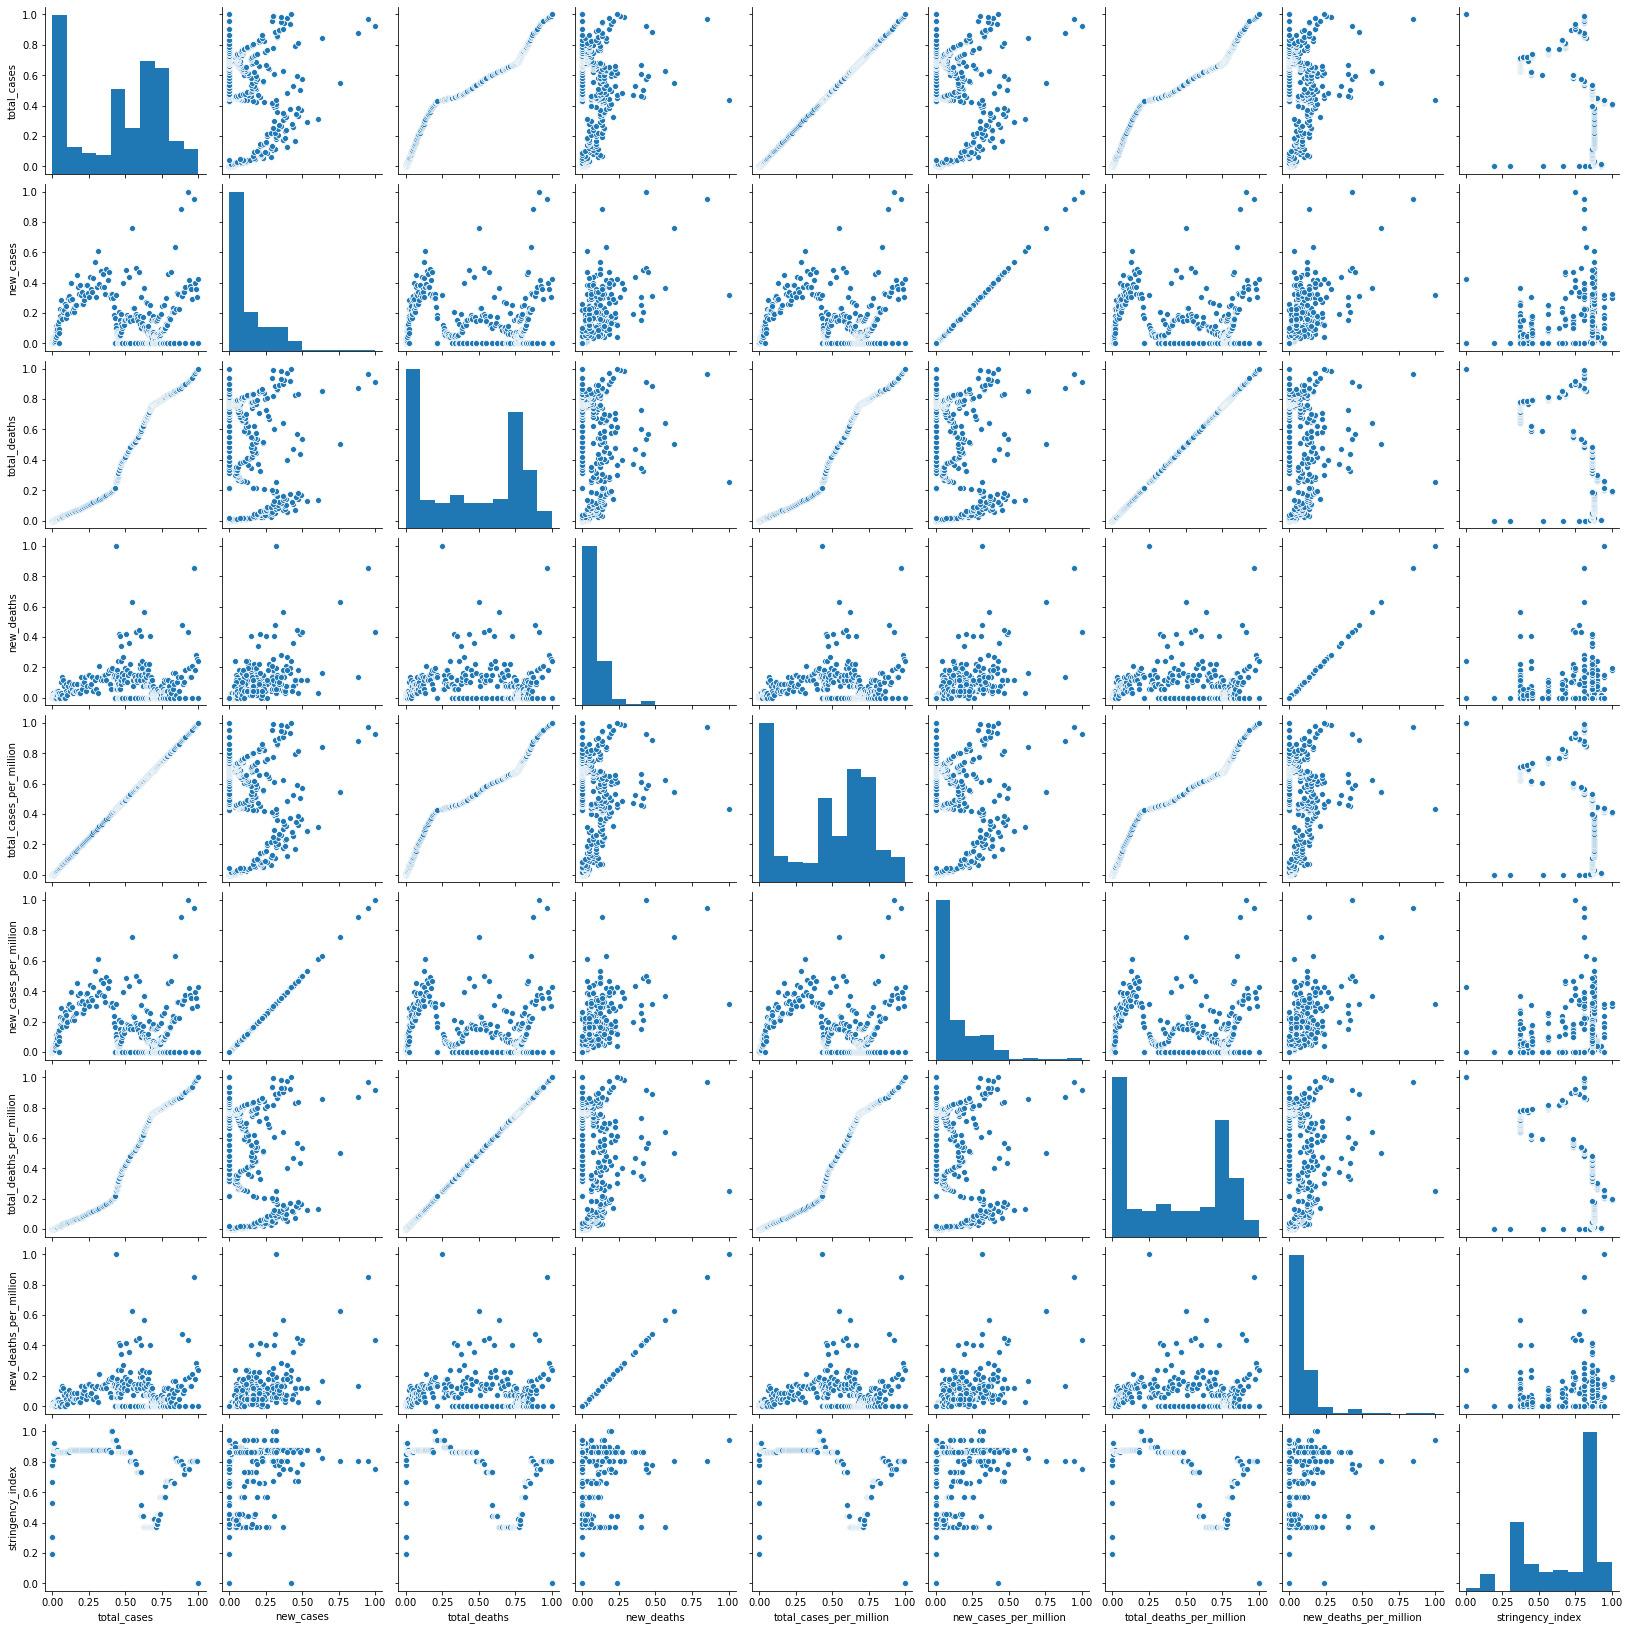

In [37]:
# correlogram
sn.pairplot(scaled_data)
plt.show()

### 1.2 Vaccinations

In [341]:
data_vax = data["Vaccinations"]

plt.figure(figsize=(25, 8))
plt.scatter(data_vax['date'], data_vax['total_vaccinations'], s=100, c='purple')
plt.xticks(rotation=80)
plt.show()

### 1.3 Mobility Reports

In [1621]:
# 2020 mobility report for 'all'
data_mob_0 = data["Mobility_Report_2020"]
data_mob_0 = data_mob_20[data_mob_20["sub_region_1"] == 'all']
# data_mob_20 = data_mob_20.set_index('date')

# 2021 mobility report for 'all'
data_mob_1 = data["Mobility_Report_2021"]
data_mob_1 = data_mob_21[data_mob_21["sub_region_1"] == 'all']
# data_mob_21 = data_mob_21.set_index('date')

In [1622]:
# concatenate both mobility reports to form one dataset
data_mobx = pd.concat([data_mob_20, data_mob_21])
data_mobx.drop(['sub_region_1'], axis=1)

date  retail_and_recreation_percent_change_from_baseline  \
0    2020-02-15                                               -2.0    
12   2020-02-16                                               -5.0    
24   2020-02-17                                               -6.0    
36   2020-02-18                                               -6.0    
48   2020-02-19                                               -7.0    
...         ...                                                ...    
1104 2021-04-03                                              -23.0    
1116 2021-04-04                                              -26.0    
1128 2021-04-05                                              -27.0    
1140 2021-04-06                                              -27.0    
1152 2021-04-07                                              -28.0    

      grocery_and_pharmacy_percent_change_from_baseline  \
0                                                  -2.0   
12                                                 -7.0   
24                                                 -7.0   
36                                                 -8.0   
48                                                 -7.0   
...                                                 ...   
1104                                               -7.0   
1116                                               -9.0   
1128                                              -10.0   
1140                                              -11.0   
1152                                              -10.0   

      parks_percent_change_from_baseline  \
0                                   -3.0   
12                                  -2.0   
24                                  -6.0   
36                                  -4.0   
48                                  -2.0   
...                                  ...   
1104                               -46.0   
1116                               -42.0   
1128                               -46.0   
1140                               -44.0   
1152                               -45.0   

      transit_stations_percent_change_from_baseline  \
0                                               0.0   
12                                             -1.0   
24                                             -1.0   
36                                             -2.0   
48                                             -3.0   
...                                             ...   
1104                                          -31.0   
1116                                          -31.0   
1128                                          -35.0   
1140                                          -32.0   
1152                                          -33.0   

      workplaces_percent_change_from_baseline  \
0                                         0.0   
12                                        8.0   
24                                        8.0   
36                                        8.0   
48                                        8.0   
...                                       ...   
1104                                    -31.0   
1116                                    -29.0   
1128                                    -31.0   
1140                                    -31.0   
1152                                    -32.0   

      residential_percent_change_from_baseline  
0                                          2.0  
12                                         0.0  
24                                         0.0  
36                                         1.0  
48                                         1.0  
...                                        ...  
1104                                       0.0  
1116                                       1.0  
1128                                       1.0  
1140                                       2.0  
1152                                       2.0  

[418 rows x 7 columns]

## 2. Visualizations

In [1607]:
# concatenate General and Mobility Report
# data_vax_indexed = data_vax.set_index('date')
# data_vax_indexed = data_vax_indexed.drop(['vaccine', 'source_url'], axis=1)
# data_vax_indexed = data_vax_indexed.fillna(0)

general_mob = pd.concat([general_data, data_mob], axis=1)

general_mob = general_mob.fillna(0)

In [1608]:
general_mob[general_mob.duplicated() == True] # returns duplicated rows

# clean duplications
clean_data = general_mob.drop_duplicates()

## 3. Analysis

In [932]:
clean_data.describe()

total_cases    new_cases  total_deaths  new_deaths  \
count     792.000000   792.000000    792.000000  792.000000   
mean    38269.309343   233.936869    381.082071    2.452020   
std     56488.808224   457.851613    610.171361    5.888146   
min         0.000000     0.000000      0.000000    0.000000   
25%         0.000000     0.000000      0.000000    0.000000   
50%         0.000000     0.000000      0.000000    0.000000   
75%     85773.500000   250.500000    686.000000    2.000000   
max    185278.000000  3544.000000   1942.000000   67.000000   

       total_cases_per_million  new_cases_per_million  \
count               792.000000             792.000000   
mean               7494.055626              45.810501   
std               11061.873814              89.658417   
min                   0.000000               0.000000   
25%                   0.000000               0.000000   
50%                   0.000000               0.000000   
75%               16796.524000              49.053750   
max               36281.910000             694.001000   

       total_deaths_per_million  new_deaths_per_million  stringency_index  \
count                792.000000              792.000000        792.000000   
mean                  74.625090                0.480163         32.497159   
std                  119.486323                1.153028         37.863631   
min                    0.000000                0.000000          0.000000   
25%                    0.000000                0.000000          0.000000   
50%                    0.000000                0.000000          0.000000   
75%                  134.335750                0.392000         80.560000   
max                  380.291000               13.120000        100.000000   

       retail_and_recreation_percent_change_from_baseline  \
count                                         792.000000    
mean                                          -16.415404    
std                                            18.640600    
min                                           -67.000000    
25%                                           -28.000000    
50%                                            -5.500000    
75%                                             0.000000    
max                                             3.000000    

       grocery_and_pharmacy_percent_change_from_baseline  \
count                                         792.000000   
mean                                          -10.962121   
std                                            13.359318   
min                                           -59.000000   
25%                                           -19.000000   
50%                                            -3.000000   
75%                                             0.000000   
max                                             3.000000   

       parks_percent_change_from_baseline  \
count                          792.000000   
mean                           -19.135101   
std                             20.277672   
min                            -65.000000   
25%                            -38.250000   
50%                             -5.000000   
75%                              0.000000   
max                              4.000000   

       transit_stations_percent_change_from_baseline  \
count                                     792.000000   
mean                                      -21.666667   
std                                        24.077204   
min                                       -77.000000   
25%                                       -40.000000   
50%                                        -7.000000   
75%                                         0.000000   
max                                         2.000000   

       workplaces_percent_change_from_baseline  \
count                               792.000000   
mean                                -13.450758   
std                                  15.645168   
min                            

In [935]:
# scale
scaler = MinMaxScaler()

cases_data = pd.DataFrame(scaler.fit_transform(clean_data), columns=clean_data.columns, index=clean_data.index)
# cases_data
cases_data.describe()

total_cases   new_cases  total_deaths  new_deaths  \
count   792.000000  792.000000    792.000000  792.000000   
mean      0.206551    0.066009      0.196232    0.036597   
std       0.304887    0.129191      0.314197    0.087883   
min       0.000000    0.000000      0.000000    0.000000   
25%       0.000000    0.000000      0.000000    0.000000   
50%       0.000000    0.000000      0.000000    0.000000   
75%       0.462945    0.070683      0.353244    0.029851   
max       1.000000    1.000000      1.000000    1.000000   

       total_cases_per_million  new_cases_per_million  \
count               792.000000             792.000000   
mean                  0.206551               0.066009   
std                   0.304887               0.129191   
min                   0.000000               0.000000   
25%                   0.000000               0.000000   
50%                   0.000000               0.000000   
75%                   0.462945               0.070683   
max                   1.000000               1.000000   

       total_deaths_per_million  new_deaths_per_million  stringency_index  \
count                792.000000              792.000000        792.000000   
mean                   0.196232                0.036598          0.324972   
std                    0.314197                0.087883          0.378636   
min                    0.000000                0.000000          0.000000   
25%                    0.000000                0.000000          0.000000   
50%                    0.000000                0.000000          0.000000   
75%                    0.353245                0.029878          0.805600   
max                    1.000000                1.000000          1.000000   

       retail_and_recreation_percent_change_from_baseline  \
count                                         792.000000    
mean                                            0.722637    
std                                             0.266294    
min                                             0.000000    
25%                                             0.557143    
50%                                             0.878571    
75%                                             0.957143    
max                                             1.000000    

       grocery_and_pharmacy_percent_change_from_baseline  \
count                                         792.000000   
mean                                            0.774804   
std                                             0.215473   
min                                             0.000000   
25%                                             0.645161   
50%                                             0.903226   
75%                                             0.951613   
max                                             1.000000   

       parks_percent_change_from_baseline  \
count                          792.000000   
mean                             0.664709   
std                              0.293879   
min                              0.000000   
25%                              0.387681   
50%                              0.869565   
75%                              0.942029   
max                              1.000000   

       transit_stations_percent_change_from_baseline  \
count                                     792.000000   
mean                                        0.700422   
std                                         0.304775   
min                                         0.000000   
25%                                         0.468354   
50%                                         0.886076   
75%                                         0.974684   
max                                         1.000000   

       workplaces_percent_change_from_baseline  \
count                               792.000000   
mean                                  0.694366   
std                                   0.195565   
min                                   0.000000   
25%   

In [936]:
# plot correlations map
plt.figure(figsize=(12, 8))
correlations1 = cases_data.corr()
sn.heatmap(correlations1, annot=True, cmap="copper")
plt.show()

### 3.1. LSTM: Predict To a 1 Month Projection

#### 3.1.1. 'new_cases'

In [1546]:
general_data = general_data.fillna(0)

# Select features (columns) to be involved intro training and predictions
cols = list(general_data[['new_cases']])

# Extract dates (will be used in visualization)
datelist_train = list(general_data['date'])
datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (426, 1)
All timestamps == 426
Featured selected: ['new_cases']


In [1547]:
dataset_train = general_data[cols].astype(str)
for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',', '')

dataset_train = dataset_train.astype(float)

# Using multiple features (predictors)
training_set = dataset_train.values

print('Shape of training set == {}.'.format(training_set.shape))
training_set

Shape of training set == (426, 1).


array([[2.000e+00],
       [0.000e+00],
       [2.000e+00],
       [0.000e+00],
       [0.000e+00],
       [2.000e+00],
       [0.000e+00],
       [0.000e+00],
       [6.000e+00],
       [3.000e+00],
       [1.000e+00],
       [0.000e+00],
       [0.000e+00],
       [0.000e+00],
       [0.000e+00],
       [2.000e+00],
       [0.000e+00],
       [0.000e+00],
       [1.000e+00],
       [0.000e+00],
       [3.000e+00],
       [0.000e+00],
       [2.000e+00],
       [1.500e+01],
       [9.000e+00],
       [0.000e+00],
       [4.000e+00],
       [3.000e+00],
       [1.100e+01],
       [1.800e+01],
       [1.500e+01],
       [1.000e+01],
       [2.200e+01],
       [2.100e+01],
       [1.500e+01],
       [1.200e+01],
       [1.300e+01],
       [1.800e+01],
       [2.100e+01],
       [2.100e+01],
       [2.500e+01],
       [2.100e+01],
       [3.300e+01],
       [4.000e+01],
       [4.800e+01],
       [3.800e+01],
       [2.700e+01],
       [6.200e+01],
       [5.300e+01],
       [1.280e+02],


In [1548]:
# Feature Scaling
sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(training_set)

# sc_predict = MinMaxScaler()
# sc_predict.fit_transform(training_set[:, 0:1])

In [1549]:
# Creating a data structure with 60 timestamps and 1 output
X_train = []
y_train = []

n_future = 30   # Number of days we want top predict into the future
n_past = 60     # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1]])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (337, 60, 1).
y_train shape == (337, 1).


In [1550]:
# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))

# Adding 2nd LSTM layer
model.add(LSTM(units=10, return_sequences=False))

# Adding Dropout
model.add(Dropout(0.25))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')

In [1551]:
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=30, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/30
2/2 [==============================] - 14s 7s/step - loss: 0.0422 - val_loss: 0.0468

Epoch 00001: val_loss improved from inf to 0.04681, saving model to weights.h5
Epoch 2/30
2/2 [==============================] - 0s 223ms/step - loss: 0.0429 - val_loss: 0.0731

Epoch 00002: val_loss did not improve from 0.04681
Epoch 3/30
2/2 [==============================] - 0s 196ms/step - loss: 0.0276 - val_loss: 0.0515

Epoch 00003: val_loss did not improve from 0.04681
Epoch 4/30
2/2 [==============================] - 0s 202ms/step - loss: 0.0222 - val_loss: 0.0498

Epoch 00004: val_loss did not improve from 0.04681
Epoch 5/30
2/2 [==============================] - 0s 212ms/step - loss: 0.0242 - val_loss: 0.0538

Epoch 00005: val_loss did not improve from 0.04681
Epoch 6/30
2/2 [==============================] - 0s 204ms/step - loss: 0.0205 - val_loss: 0.0568

Epoch 00006: val_loss did not improve from 0.04681
Epoch 7/30
2/2 [==============================] - 0s 195ms/step - loss: 0.

In [1552]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

In [1553]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

In [1561]:
new_cases = sc.inverse_transform(predictions_future)
new_cases

array([[473.35074],
       [471.2035 ],
       [463.42575],
       [453.5162 ],
       [459.71893],
       [467.10013],
       [472.1227 ],
       [473.9126 ],
       [473.35672],
       [465.75854],
       [454.9136 ],
       [462.16983],
       [471.74997],
       [477.92444],
       [479.68362],
       [471.43445],
       [458.1405 ],
       [445.40866],
       [462.82635],
       [481.16235],
       [492.2101 ],
       [494.49973],
       [491.2066 ],
       [476.65347],
       [457.62418],
       [467.7891 ],
       [482.3949 ],
       [494.44305],
       [499.38843],
       [498.03513]], dtype=float32)

#### 3.1.2. 'new_deaths'

In [1556]:
cols0 = list(general_data[['new_deaths']])

dataset_train0 = general_data[cols0].astype(str)
for i in cols0:
    for j in range(0, len(dataset_train0)):
        dataset_train0[i][j] = dataset_train0[i][j].replace(',', '')

dataset_train0 = dataset_train0.astype(float)

training_set0 = dataset_train0.values

sc0 = MinMaxScaler()
training_set_scaled0 = sc0.fit_transform(training_set0)

X_train0 = []
y_train0 = []

for i in range(n_past, len(training_set_scaled0) - n_future +1):
    X_train0.append(training_set_scaled0[i - n_past:i, 0:dataset_train0.shape[1]])
    y_train0.append(training_set_scaled0[i + n_future - 1:i + n_future, 0])

X_train0, y_train0 = np.array(X_train0), np.array(y_train0)

In [1557]:
history0 = model.fit(X_train0, y_train0, shuffle=True, epochs=30, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/30
2/2 [==============================] - 6s 5s/step - loss: 0.0158 - val_loss: 0.0186

Epoch 00001: val_loss improved from 0.04681 to 0.01865, saving model to weights.h5
Epoch 2/30
2/2 [==============================] - 0s 215ms/step - loss: 0.0139 - val_loss: 0.0183

Epoch 00002: val_loss improved from 0.01865 to 0.01825, saving model to weights.h5
Epoch 3/30
2/2 [==============================] - 1s 238ms/step - loss: 0.0137 - val_loss: 0.0188

Epoch 00003: val_loss did not improve from 0.01825
Epoch 4/30
2/2 [==============================] - 0s 277ms/step - loss: 0.0138 - val_loss: 0.0194

Epoch 00004: val_loss did not improve from 0.01825
Epoch 5/30
2/2 [==============================] - 1s 279ms/step - loss: 0.0141 - val_loss: 0.0193

Epoch 00005: val_loss did not improve from 0.01825
Epoch 6/30
2/2 [==============================] - 0s 217ms/step - loss: 0.0140 - val_loss: 0.0187

Epoch 00006: val_loss did not improve from 0.01825
Epoch 7/30
2/2 [=======================

In [1558]:
predictions_future0 = model.predict(X_train0[-n_future:])

predictions_train0 = model.predict(X_train0[n_past:])

In [1562]:
new_deaths = sc0.inverse_transform(predictions_future0)
new_deaths

array([[5.088584 ],
       [5.141839 ],
       [5.133327 ],
       [5.07762  ],
       [5.172878 ],
       [5.3540535],
       [5.478017 ],
       [5.532888 ],
       [5.470624 ],
       [5.3392005],
       [5.1876   ],
       [5.224183 ],
       [5.2913465],
       [5.351817 ],
       [5.3889537],
       [5.338166 ],
       [5.230867 ],
       [5.1044784],
       [5.1618342],
       [5.200537 ],
       [5.287279 ],
       [5.3512545],
       [5.3858094],
       [5.332113 ],
       [5.224053 ],
       [5.142821 ],
       [5.208443 ],
       [5.308622 ],
       [5.553425 ],
       [5.760517 ]], dtype=float32)

### 3.2. Predict Stringency Index & Mobility on the Predicted 'new_cases' and 'new_deaths'

In [1648]:
# merge mobility dataset with cases dataset
mob = data_mobx.drop(['sub_region_1'], axis=1)
mob['date'] = mob['date'].astype(str)
merged = pd.merge(general_data, mob)
merged0 = merged.drop(['date'], axis=1)

#scale 
merged_scaled = pd.DataFrame(sc.fit_transform(merged0), columns=merged0.columns)

#### 3.2.1. Stringency Index

In [1649]:
"""train on Stringency Index"""
X = merged_scaled[['new_cases', 'new_deaths']]
y = merged_scaled[['stringency_index']]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2021)

In [1659]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train.values.ravel())

LinearRegression()

#### 3.2.2. Mobility rates

In [1663]:
"""train on Mobility data"""
X0 = merged_scaled[['new_cases', 'new_deaths']]
y0 = merged_scaled[['retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline', 'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline']]

from sklearn.model_selection import train_test_split

X_train0, X_test0, y_train0, y_test0 = train_test_split(X0, y0, test_size=0.3, random_state=2021)

In [1677]:
lr0 = LinearRegression()
lr0.fit(X_train0, y_train0.values)

LinearRegression()

In [ ]:
"""
#
#
#
#
"""